In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

In [2]:
# Paths
dataset_path = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

NUM_CLASSES = 7

In [3]:
# Load dataset
data = np.loadtxt(dataset_path, delimiter=',')
print(f"Loaded {len(data)} samples from {dataset_path}")

# Split into features and labels
X_dataset = data[:, 1:] 
y_dataset = data[:, 0].astype(int) 

# Calculate hand landmark dimensions
num_landmarks = 21  
num_dimensions = X_dataset.shape[1] // (num_landmarks * 2) 

# Reshape data for CNN
X_reshaped = X_dataset.reshape(X_dataset.shape[0], num_landmarks, 2)

# Check class distribution
unique_classes, counts = np.unique(y_dataset, return_counts=True)
print("Class distribution:")
for cls, count in zip(unique_classes, counts):
    print(f"  Class {cls}: {count} samples")

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, 
    y_dataset, 
    train_size=0.8, 
    random_state=42
)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Loaded 3049 samples from model/keypoint_classifier/keypoint.csv
Class distribution:
  Class 0: 434 samples
  Class 1: 372 samples
  Class 2: 443 samples
  Class 3: 338 samples
  Class 4: 1086 samples
  Class 5: 273 samples
  Class 6: 103 samples
Training samples: 2439, Test samples: 610


In [4]:
# Build CNN model
inputs = tf.keras.Input(shape=(num_landmarks, 2))

# Reshape to add channel dimension for Conv1D
x = tf.keras.layers.Reshape((num_landmarks, 2, 1))(inputs)

# First convolutional block
x = tf.keras.layers.Conv2D(32, (3, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 1))(x)

# Second convolutional block
x = tf.keras.layers.Conv2D(64, (3, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 1))(x)

# Third convolutional block 
x = tf.keras.layers.Conv2D(128, (3, 1), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation('relu')(x)

# Flatten and dense layers
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 21, 2, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 21, 2, 32)      │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 21, 2, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 21, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 2, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 2, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 2, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5, 2, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,351 (192.78 KB)

 Trainable params: 48,903 (191.03 KB)

 Non-trainable params: 448 (1.75 KB)

In [5]:
# Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, 
    verbose=1, 
    save_weights_only=False,
    save_best_only=True,
    monitor='val_accuracy'
)
es_callback = tf.keras.callbacks.EarlyStopping(
    patience=20, 
    verbose=1,
    monitor='val_accuracy'
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=0.00001
)

# Train model
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback, reduce_lr]
)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")


Epoch 1/500
61/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4355 - loss: 1.5105 
Epoch 1: val_accuracy improved from -inf to 0.33934, saving model to model/keypoint_classifier/keypoint_classifier.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4780 - loss: 1.4205 - val_accuracy: 0.3393 - val_loss: 1.8505 - learning_rate: 0.0010
Epoch 2/500
64/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8400 - loss: 0.5516
Epoch 2: val_accuracy did not improve from 0.33934
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8441 - loss: 0.5396 - val_accuracy: 0.3393 - val_loss: 1.9763 - learning_rate: 0.0010
Epoch 3/500
63/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8780 - loss: 0.4331
Epoch 3: val_accuracy improved from 0.33934 to 0.34754, saving model to model/keypoint_classifier/keypoint_classifier.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8816 - loss: 0.4216 - val_accuracy: 0.3475 - val_loss: 1.9696 - learning_rate: 0.0010
Epoch 4/500
65/77 ━━━━━━━━━━━━━

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
INFO:tensorflow:Assets written to: /var/folders/7y/sgl50nfj39ncf6k_4f12dp140000gn/T/tmp4ik5sojg/assets


INFO:tensorflow:Assets written to: /var/folders/7y/sgl50nfj39ncf6k_4f12dp140000gn/T/tmp4ik5sojg/assets


Saved artifact at '/var/folders/7y/sgl50nfj39ncf6k_4f12dp140000gn/T/tmp4ik5sojg'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21, 2), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  13794386256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794388368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794388752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794387408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794387216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794386832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794387600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794387792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794389712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794389328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13794388560: Ten

W0000 00:00:1745376525.216386 45082680 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1745376525.216426 45082680 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1745376525.221937 45082680 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled


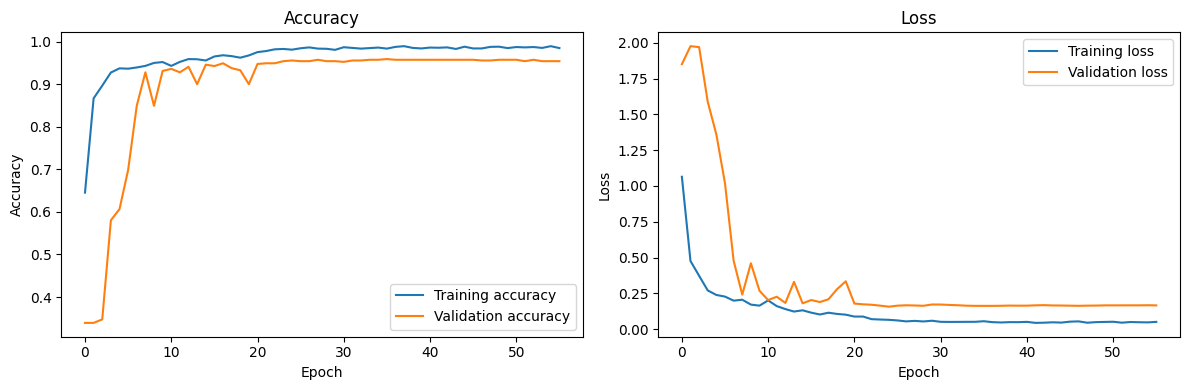


Testing TFLite model with a sample:
Sample true class: 4
TFLite predicted probabilities: [3.6875804e-08 8.7064293e-11 2.0188544e-07 2.2307052e-11 9.9999332e-01
 3.7915387e-12 6.4069332e-06]
TFLite predicted class: 4


/Users/satomi/Documents/GitHub/AR-Drawing/venv/lib/python3.11/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [6]:
# Predict and evaluate
y_pred = np.argmax(model.predict(X_test), axis=1)

# Convert model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open(tflite_save_path, 'wb') as f:
    f.write(tflite_model)
print(f"Model saved to {tflite_save_path}")


# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Test the TFLite model
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nTesting TFLite model with a sample:")
test_sample = X_test[0:1] 

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], test_sample.astype(np.float32))

# Run inference
interpreter.invoke()

# Get output tensor
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(f"Sample true class: {y_test[0]}")
print(f"TFLite predicted probabilities: {tflite_results[0]}")
print(f"TFLite predicted class: {np.argmax(tflite_results[0])}")